In [1]:
import pandas as pd
import numpy as np
#import itertools
import sklearn.metrics as met
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import scipy as sp

import sys
sys.path.insert(0, '../../notebooks/libs/')
import FeatureExtraction as FE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

/home/weenkus/anaconda3/envs/python2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
training = pd.read_csv('../../csv/chat_based_features_training.csv')
test = pd.read_csv('../../csv/chat_based_features_test.csv')

In [ ]:
# Filtering chat based
#minimal_number_of_messages_treshold = 2
#training = training[training['number of messages sent'] >= minimal_number_of_messages_treshold]
#test = test[test['number of messages sent'] >= minimal_number_of_messages_treshold]

In [32]:
features = ['number of conversation', 'percent of conversations started by the author', 'number of messages sent', 'average percent of lines in conversation', 'number of characters sent by the author']

important_features = ['percent of conversations started by the author',
                      'difference between two preceding lines in seconds', 'number of messages sent',
                      'average percent of lines in conversation', 
                      
                      'number of characters sent by the author', 'mean time of messages sent',
                      
                      'avg number of unique authors interacted with per conversation', 
                      'total unique authors and unique per chat difference',
                
                      'total question marks',
                      'total author question marks', 'avg author question marks',
                      'author and conversation quetsion mark differnece', 'pos word count author',
                      'prof word count author']
#training_sparse = sp.sparse.csr_matrix(training[features].ix[:,1:].values, dtype=float)[:,:-1]
#test_sparse = sp.sparse.csr_matrix(test[features].ix[:,1:].values, dtype=float)[:,:-1]

In [3]:
training_xml = '../../dataset/training/pan12-sexual-predator-identification-training-corpus-2012-05-01.xml'
test_xml = '../../dataset/test/pan12-sexual-predator-identification-test-corpus-2012-05-17.xml'

In [4]:
# Filtering TF-IDF
# Original documents_training = FE.prepare_for_tf_idf(training_xml, False)

documents_training = FE.prepare_for_tf_idf(training_xml, False)
documents_test = FE.prepare_for_tf_idf(test_xml, False)

In [5]:
tfidf=TfidfVectorizer(stop_words='english', min_df=3, max_features=2500) #max_features=2500
matrix_training=tfidf.fit_transform(documents_training)
matrix_testing=tfidf.transform(documents_test)

In [6]:
#print matrix_training.shape
#print training_sparse.shape

In [7]:
column_names = training.columns.values.tolist()[1:-1]
print column_names

['number of conversation', 'percent of conversations started by the author', 'difference between two preceding lines in seconds', 'number of messages sent', 'average percent of lines in conversation', 'average percent of characters in conversation', 'number of characters sent by the author', 'mean time of messages sent', 'number of unique contacted authors', 'avg number of unique authors interacted with per conversation', 'total unique authors and unique per chat difference', 'conversation num and total unique authors difference', 'average question marks per conversations', 'total question marks', 'total author question marks', 'avg author question marks', 'author and conversation quetsion mark differnece', 'author total negative in author conv', 'author total neutral in author conv', 'author total positive in author conv', ' authortotal compound in author conv', 'pos word count author', 'neg word count author', 'prof word count author']


In [16]:
training_all = sp.sparse.hstack((training[column_names], matrix_training))
test_all = sp.sparse.hstack((test[column_names], matrix_testing))

In [9]:
scaler=StandardScaler(with_mean=False)
training_all=scaler.fit_transform(training_all)
test_all=scaler.transform(test_all)

In [10]:
#training_all = normalize(training_all, norm='l1', axis=1)
#test_all = normalize(test_all, norm='l1', axis=1)

In [ ]:
model = xgb.XGBClassifier(max_depth=13, n_estimators=280, learning_rate=0.028, scale_pos_weight=5, gamma=4,
                          min_child_weight=5, subsample=1, max_delta_step=3)

model.fit(training_all, training[['is sexual predator']])

/home/weenkus/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=4, learning_rate=0.028, max_delta_step=3, max_depth=13,
       min_child_weight=5, missing=None, n_estimators=280, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=5, seed=0, silent=True, subsample=1)

In [ ]:
prediction = model.predict(test_all)

In [ ]:
print 'Accuracy: ', met.accuracy_score(test[['is sexual predator']], prediction) 
print 'Precision: ', met.precision_score(test[['is sexual predator']], prediction)
print 'Recall:', met.recall_score(test[['is sexual predator']], prediction)
print 'F1:', met.f1_score(test[['is sexual predator']], prediction)
print 'F0.5:', met.fbeta_score(test[['is sexual predator']], prediction, 0.5)

In [ ]:
(max_depth=13, n_estimators=280, learning_rate=0.065, scale_pos_weight=5, gamma=4,
                          min_child_weight=5, subsample=1, max_delta_step=5)
Accuracy:  0.999446735741
Precision:  0.803652968037
Recall: 0.692913385827
F1: 0.744186046512
F0.5: 0.778761061947

(max_depth=13, n_estimators=280, learning_rate=0.28, scale_pos_weight=5, gamma=4,
                          min_child_weight=5, subsample=1, max_delta_step
Accuracy:  0.999437590877
Precision:  0.819512195122
Recall: 0.661417322835
F1: 0.732026143791
F0.5: 0.782122905028

In [ ]:
column_names = training.columns.values.tolist()[1:-1]
print column_names

In [ ]:
#training.tail()

In [ ]:
# Remove scale_post_weight -> smaller F1 score, lower recall but increase precision
# Remove gama for bigger precision
sex_offender0 = xgb.XGBClassifier(max_depth=13, n_estimators=280, learning_rate=0.028, scale_pos_weight=5, gamma=4,
                          min_child_weight=5, subsample=1, max_delta_step=3)
sex_offender1 = xgb.XGBClassifier(max_depth=25, n_estimators=300)
sex_offender2 = xgb.XGBClassifier(max_depth=5, n_estimators=220, learning_rate=0.007, scale_pos_weight=20, gamma=2)
sex_offender3 = xgb.XGBClassifier(max_depth=3, n_estimators=400)
sex_offender4 = xgb.XGBClassifier(max_depth=7, n_estimators=100)

In [ ]:
sex_offender0.fit(training_all, training[['is sexual predator']])
sex_offender1.fit(training_all, training[['is sexual predator']])
sex_offender2.fit(training_all, training[['is sexual predator']])
sex_offender3.fit(training_all, training[['is sexual predator']])
sex_offender4.fit(training_all, training[['is sexual predator']])

In [ ]:
prediction0 = sex_offender0.predict(test_all)
prediction1 = sex_offender1.predict(test_all)
prediction2 = sex_offender2.predict(test_all)
prediction3 = sex_offender3.predict(test_all)
prediction4 = sex_offender4.predict(test_all)

In [ ]:
def bagging(vote_number, prediction_list):
    total_prediction = []
    for i in range(len(prediction_list[0])):
        voters = 0
        
        for prediction in prediction_list:
            if prediction[i] == 1:
                voters += 1
                
        if voters >= vote_number:
            total_prediction.append(1)
        else:
            total_prediction.append(0)
                
    return np.array(total_prediction)

In [ ]:
prediction = bagging(5, [prediction0, prediction1, prediction2, prediction3, prediction4])

In [ ]:
print 'Accuracy: ', met.accuracy_score(test[['is sexual predator']], prediction) 
print 'Precision: ', met.precision_score(test[['is sexual predator']], prediction)
print 'Recall:', met.recall_score(test[['is sexual predator']], prediction)
print 'F1:', met.fbeta_score(test[['is sexual predator']], prediction, 1)
print 'F0.5:', met.fbeta_score(test[['is sexual predator']], prediction, 0.5)

In [ ]:
forest = RandomForestClassifier(n_estimators = 100)

max_f1 = 0
best_features = []

for num_features in range(2, len(column_names)-1):
    for column_name_subset in itertools.combinations(column_names, num_features):

        forest = forest.fit(training[list(column_name_subset)], np.ravel(training.iloc[:,[9]]))
        prediction = forest.predict(test[list(column_name_subset)])

        print column_name_subset
        print 'Accuracy: ', met.accuracy_score(test[['is sexual predator']], prediction) 
        print 'Precision: ', met.precision_score(test[['is sexual predator']], prediction)
        print 'Recall:', met.recall_score(test[['is sexual predator']], prediction)
        print 'F1:', met.f1_score(test[['is sexual predator']], prediction)
        print "\n\n"

        f1 = met.f1_score(test[['is sexual predator']], prediction)
        if max_f1 < f1:
            max_f1 = f1
            best_features =  column_name_subset
                                                                                                 
print max_f1
print best_features

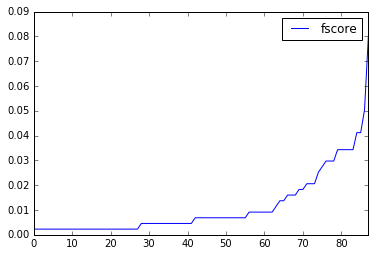

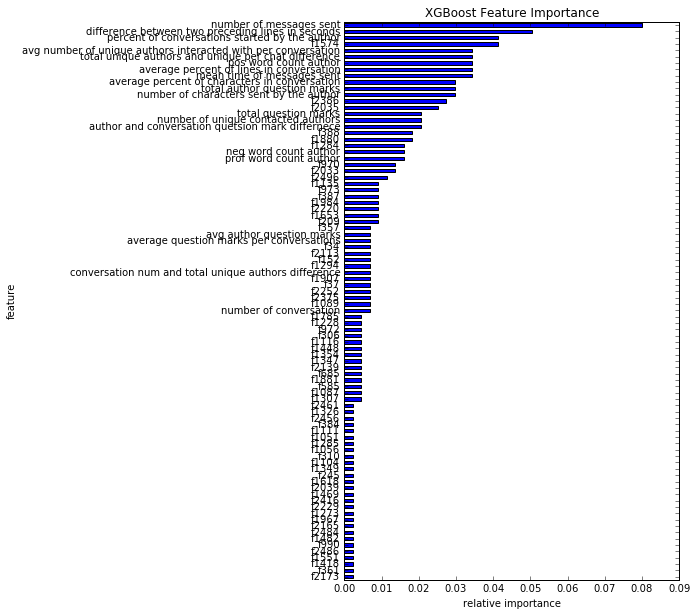

In [20]:
import pandas as pd
import xgboost as xgb
import operator
from matplotlib import pylab as plt

%matplotlib inline  

def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()


features = training.columns.values.tolist()[1:-1]
x_train = training_all
y_train = training['is sexual predator']
ceate_feature_map(features)

xgb_params = {"objective": "binary:logistic", "eta": 0.28, "max_depth": 13, "seed": 42, "silent": 1,
             "n_estimators": 280, "gamma":4, "min_child_weight":5, "scale_pos_weight":5}
num_rounds = 1000

dtrain = xgb.DMatrix(x_train, label=y_train)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [21]:
dtest = xgb.DMatrix(test_all, label=test['is sexual predator'])
#gbdt.fit(dtest[predictors], dtest['is sexual preadtor'],eval_metric='auc')
prediction = gbdt.predict(dtest)

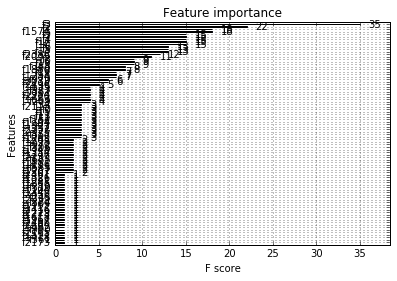

In [22]:
xgb.plot_importance(gbdt)

In [24]:
xgb.to_graphviz(gbdt, num_trees=2)
#print prediction

OSError: [Errno 12] Cannot allocate memory

In [ ]:
print 'Accuracy: ', met.accuracy_score(test[['is sexual predator']], prediction) 
print 'Precision: ', met.precision_score(test[['is sexual predator']], prediction)
print 'Recall:', met.recall_score(test[['is sexual predator']], prediction)
print 'F1:', met.fbeta_score(test[['is sexual predator']], prediction, 1)
print 'F0.5:', met.fbeta_score(test[['is sexual predator']], prediction, 0.5)

In [ ]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

target = 'is sexual predator'

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['is sexual preadtor'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['is sexual preadtor'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['is sexual preadtor'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
#Choose all predictors except target & IDcols
predictors = training.columns.values.tolist()[1:-1]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, training, predictors)